In [9]:
# Install any required packages (TensorFlow/Keras is pre-installed in Colab)
!pip install scikit-learn matplotlib seaborn

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import cv2  # For image saving (available in Colab)
from PIL import Image
import random

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print("Setup complete. TensorFlow version:", tf.__version__)

Setup complete. TensorFlow version: 2.19.0


Dummy dataset created: 200 train images, 40 test images.
Train dir: /content/tool_wear_dataset/train
Test dir: /content/tool_wear_dataset/test


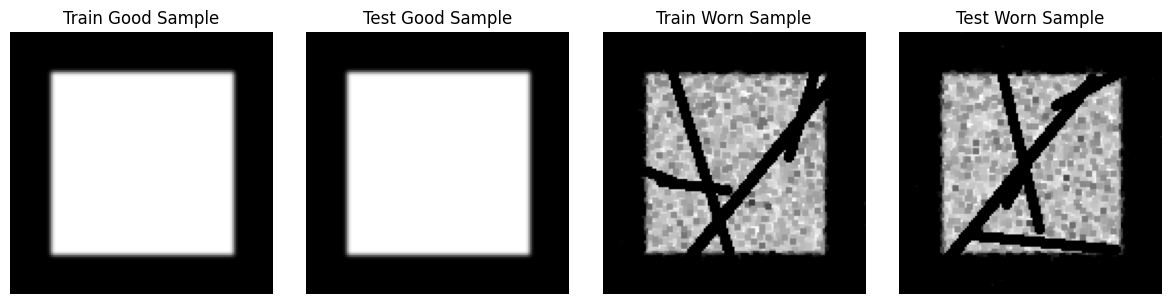

In [10]:
# Create directories for dummy dataset
base_dir = '/content/tool_wear_dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Subdirectories for classes
classes = ['good', 'worn']
for split in [train_dir, test_dir]:
    for cls in classes:
        os.makedirs(os.path.join(split, cls), exist_ok=True)

# Function to generate a synthetic "good" tool image
def generate_good_tool(size=128):
    img = np.zeros((size, size), dtype=np.uint8)
    # Draw a smooth rectangle (tool body)
    cv2.rectangle(img, (20, 20), (size-20, size-20), 255, -1)
    # Add smooth edges
    cv2.GaussianBlur(img, (5,5), 0, dst=img)
    return img

# Function to generate a synthetic "worn" tool image
def generate_worn_tool(size=128):
    img = generate_good_tool(size)
    # Add wear: random noise
    noise = np.random.normal(0, 50, img.shape).astype(np.int16)
    img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)
    # Add cracks: random lines
    for _ in range(5):
        x1, y1 = random.randint(0, size), random.randint(0, size)
        x2, y2 = random.randint(0, size), random.randint(0, size)
        cv2.line(img, (x1, y1), (x2, y2), 0, 2)
    # Erode to simulate wear
    kernel = np.ones((3,3), np.uint8)
    img = cv2.erode(img, kernel, iterations=1)
    return img

# Generate images
img_size = 128
num_train_per_class = 100
num_test_per_class = 20

for cls, generator in enumerate([generate_good_tool, generate_worn_tool]):
    # Training images
    for i in range(num_train_per_class):
        img = generator(img_size)
        img_pil = Image.fromarray(img)
        img_pil.save(os.path.join(train_dir, classes[cls], f'{cls}_{i}.png'))

    # Test images
    for i in range(num_test_per_class):
        img = generator(img_size)
        img_pil = Image.fromarray(img)
        img_pil.save(os.path.join(test_dir, classes[cls], f'{cls}_{i}.png'))

print(f"Dummy dataset created: {num_train_per_class*2} train images, {num_test_per_class*2} test images.")
print(f"Train dir: {train_dir}")
print(f"Test dir: {test_dir}")

# Visualize sample images
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, cls in enumerate(classes):
    img_path = os.path.join(train_dir, cls, os.listdir(os.path.join(train_dir, cls))[0])
    img = plt.imread(img_path)
    axes[2*i].imshow(img, cmap='gray')
    axes[2*i].set_title(f'Train {cls.title()} Sample')
    axes[2*i].axis('off')

    img_path_test = os.path.join(test_dir, cls, os.listdir(os.path.join(test_dir, cls))[0])
    img_test = plt.imread(img_path_test)
    axes[2*i+1].imshow(img_test, cmap='gray')
    axes[2*i+1].set_title(f'Test {cls.title()} Sample')
    axes[2*i+1].axis('off')
plt.tight_layout()
plt.show()

In [11]:
# Image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False  # For consistent evaluation
)

# Class labels
class_labels = list(train_generator.class_indices.keys())
print(f"Classes: {class_labels}")
print(f"Train batches: {train_generator.samples // batch_size}")
print(f"Test batches: {test_generator.samples // batch_size}")

Found 200 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Classes: ['good', 'worn']
Train batches: 6
Test batches: 1


In [12]:
# Build CNN model
model = models.Sequential([
    # Input layer
    layers.Input(shape=(128, 128, 1)),

    # Convolutional block 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Convolutional block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Convolutional block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary output
])

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()

# Callback to save best model
checkpoint = ModelCheckpoint(
    '/content/best_tool_wear_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,941,697 (49.37 MB)

 Trainable params: 12,940,225 (49.36 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [5]:
# Train the model
epochs = 20
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[checkpoint]
)

print("Training complete. Best model saved.")

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8028 - loss: 0.3825
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to /content/best_tool_wear_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.8173 - loss: 0.3559 - val_accuracy: 0.6250 - val_loss: 1.0972
Epoch 2/20
1/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 1.0000 - loss: 0.0151

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.62500
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 1.0000 - loss: 0.0151 - val_accuracy: 0.6250 - val_loss: 1.1559
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0167
Epoch 3: val_accuracy did not improve from 0.62500
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 1.0000 - loss: 0.0155 - val_accuracy: 0.6250 - val_loss: 1.1490
Epoch 4/20
1/6 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 1.0000 - loss: 2.2477e-05
Epoch 4: val_accuracy did not improve from 0.62500
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 1.0000 - loss: 2.2477e-05 - val_accuracy: 0.6250 - val_loss: 1.1496
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 0.0023
Epoch 5: val_accuracy did not improve from 0.62500
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.6250 - val_loss: 0.8969
Epoch 6/20
1/6 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 1.0000 - loss: 6.4523e-06
Epoc

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 269ms/step - accuracy: 1.0000 - loss: 5.6826e-05 - val_accuracy: 0.6562 - val_loss: 0.3648
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 0.0014
Epoch 9: val_accuracy improved from 0.65625 to 1.00000, saving model to /content/best_tool_wear_model.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.1590
Epoch 10/20
1/6 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 1.0000 - loss: 1.1819e-05
Epoch 10: val_accuracy did not improve from 1.00000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 1.0000 - loss: 1.1819e-05 - val_accuracy: 1.0000 - val_loss: 0.1527
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 2.9492e-05
Epoch 11: val_accuracy did not improve from 1.00000
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 1.0000 - loss: 3.9228e-05 - val_accuracy: 1.0000 - val_loss: 0.2186
Epoch 12/20
1/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 1.0000 - loss: 3.2580e-06
Epoch 12: val_accuracy did not improve from 1.00000
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 1.0000 - loss: 3.2580e-06 - val_accuracy: 1.0000 - val_loss: 0.2513
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0054
Epoch 13: val_accuracy did not improv

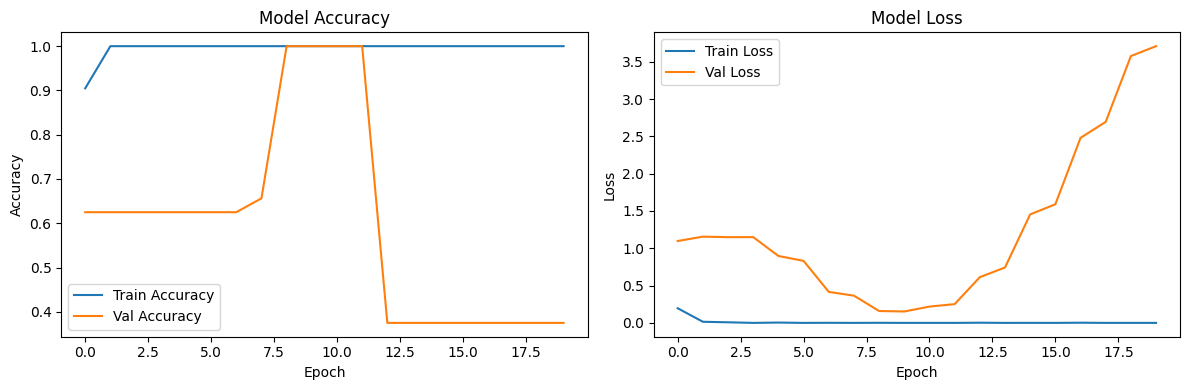

In [6]:
# Plot accuracy and loss curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step
Test Accuracy: 1.0000


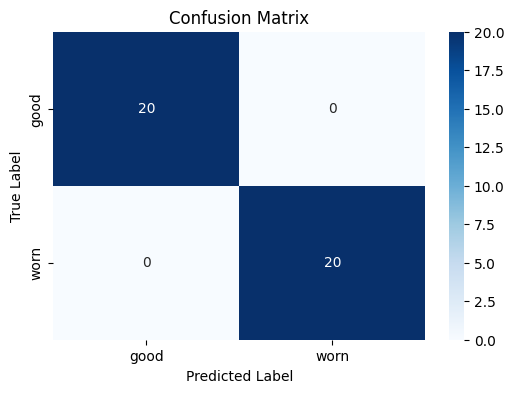


Classification Report:
              precision    recall  f1-score   support

        good       1.00      1.00      1.00        20
        worn       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [7]:
# Load best model
best_model = tf.keras.models.load_model('/content/best_tool_wear_model.h5')

# Predictions
test_generator.reset()  # Reset for prediction
y_pred = best_model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Accuracy
test_loss, test_acc = best_model.evaluate(test_generator, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_binary)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_binary, target_names=class_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


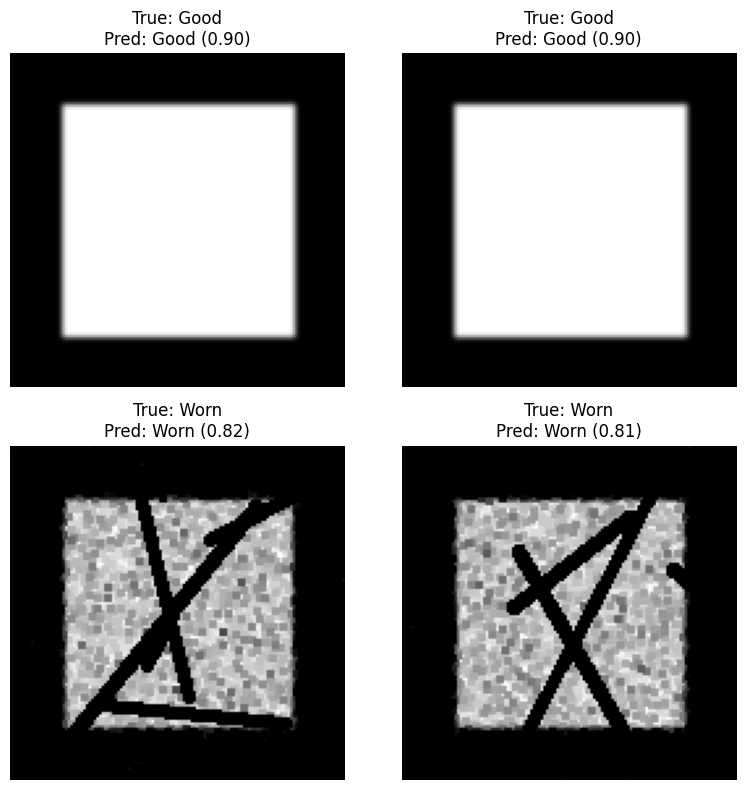

Prediction demo complete.


In [8]:
# Select 4 sample test images (2 good, 2 worn)
sample_paths = []
sample_labels = []

# 2 good samples
good_dir = os.path.join(test_dir, 'good')
for i in range(2):
    path = os.path.join(good_dir, os.listdir(good_dir)[i])
    sample_paths.append(path)
    sample_labels.append('good')

# 2 worn samples
worn_dir = os.path.join(test_dir, 'worn')
for i in range(2):
    path = os.path.join(worn_dir, os.listdir(worn_dir)[i])
    sample_paths.append(path)
    sample_labels.append('worn')

# Predict and plot
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.ravel()

for i, path in enumerate(sample_paths):
    # Load and preprocess image
    img = load_img(path, target_size=(128, 128), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    pred = best_model.predict(img_array)[0][0]
    pred_label = 'worn' if pred > 0.5 else 'good'
    confidence = pred if pred > 0.5 else 1 - pred

    # Plot
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'True: {sample_labels[i].title()}\nPred: {pred_label.title()} ({confidence:.2f})')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print("Prediction demo complete.")